In [2]:
import torch
import pandas as pd
import json
from torch_geometric.data import Data

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
import networkx as nx
from torch_geometric.utils import to_networkx
import json
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# utils

In [219]:
# 1. Label Distribution Analysis
def get_lab_dist(data, idx_to_task, show_top=False):
    print("=" * 60)
    print("📊 LABEL DISTRIBUTION ANALYSIS")
    print("=" * 60)
    
    # Convert labels to numpy for analysis
    labels = data.y[data.train_mask|data.test_mask|data.val_mask].cpu().numpy()
    train_labels = data.y[data.train_mask].cpu().numpy()
    val_labels = data.y[data.val_mask].cpu().numpy()
    test_labels = data.y[data.test_mask].cpu().numpy()
    
    
    # Calculate label statistics
    total_labels = labels.sum(axis=0)
    train_label_counts = train_labels.sum(axis=0)
    val_label_counts = val_labels.sum(axis=0)
    test_label_counts = test_labels.sum(axis=0)
    
    # Create label distribution dataframe
    label_df = pd.DataFrame({
        'Label_Index': range(len(total_labels)),
        'Total_Count': total_labels,
        'Train_Count': train_label_counts,
        'Val_Count': val_label_counts,
        'Test_Count': test_label_counts
    })
    
    # Calculate percentages
    label_df['Total_Percentage'] = (label_df['Total_Count'] / label_df['Total_Count'].sum()) * 100
    label_df['Train_Percentage'] = (label_df['Train_Count'] / label_df['Train_Count'].sum()) * 100
    label_df['Val_Percentage'] = (label_df['Val_Count'] / label_df['Val_Count'].sum()) * 100
    label_df['Test_Percentage'] = (label_df['Test_Count'] / label_df['Test_Count'].sum()) * 100
    
    print(f"Total number of unique labels: {len(total_labels)}")
    print(f"Total label instances: {total_labels.sum()}")
    print(f"Average labels per node: {total_labels.sum() / data.num_nodes:.2f}")
    print(f"Max labels per node: {labels.sum(axis=1).max()}")
    print(f"Min labels per node: {labels.sum(axis=1).min()}")

    if show_top:
        top_labels = label_df.nlargest(10, 'Total_Count')[['Label_Index', 'Total_Count', 'Total_Percentage']].copy()
    else:
        top_labels = label_df.copy()
    top_labels = top_labels.sort_values('Total_Percentage', ascending=False)
    
    # Add task names if available
    if idx_to_task:
        top_labels['Task_Name'] = top_labels['Label_Index'].map(idx_to_task)
        display_cols = ['Label_Index', 'Task_Name', 'Total_Count', 'Total_Percentage']
    else:
        display_cols = ['Label_Index', 'Total_Count', 'Total_Percentage']
    
    print(top_labels[display_cols].to_string(index=False))
    return label_df


In [227]:
nodes_df[nodes_df['y_multi_lab'].apply(len)<1]

,id,description,createdAt,type,y_multi_lab,relationships,y
330526,damlab/HIV_V3_bodysite,# Dataset Description \n\n\n## Dataset Summary...,2022-03-02 23:29:22+00:00,dataset,[],model_trainedOrFineTunedOn_dataset:damlab/HIV_...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
330560,huggingartists/alan-walker,---\nlanguage:\n- en\ntags:\n- huggingartists\...,2022-03-02 23:29:22+00:00,dataset,[],model_trainedOrFineTunedOn_dataset:huggingarti...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
330561,huggingartists/andre-3000,---\nlanguage:\n- en\ntags:\n- huggingartists\...,2022-03-02 23:29:22+00:00,dataset,[],model_trainedOrFineTunedOn_dataset:huggingarti...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
330562,huggingartists/arash,---\nlanguage:\n- en\ntags:\n- huggingartists\...,2022-03-02 23:29:22+00:00,dataset,[],model_trainedOrFineTunedOn_dataset:huggingarti...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
330563,huggingartists/architects,---\nlanguage:\n- en\ntags:\n- huggingartists\...,2022-03-02 23:29:22+00:00,dataset,[],model_trainedOrFineTunedOn_dataset:huggingarti...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
383925,YirongSun/LLaSO-Align,---\nlicense: cc-by-nc-4.0\ntask_categories:\n...,2025-08-04 08:41:02+00:00,dataset,[],,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
385422,Kwai-Keye/Thyme-RL,---\nlicense: mit\ndatasets:\n- Kwai-Keye/Thym...,2025-08-15 05:12:49+00:00,dataset,[],model_trainedOrFineTunedOn_dataset:Kwai-Keye/T...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
385752,sonalkum/AudioSkills-Llama3,---\nlanguage:\n- en\nlicense: apache-2.0\nsiz...,2025-08-18 06:32:05+00:00,dataset,[],,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
386870,ethz-vlg/mv3dpt-datasets,---\nlanguage: en\ntask_categories:\n- keypoin...,2025-08-26 13:27:02+00:00,dataset,[],,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Our graph

In [336]:
run_id = 'run_2025-10-29_10-42-09'
# run_id = 'run_2025-10-29_09-05-37'
# run_id = 'run_2025-10-11_13-12-14'

nodes_df = pd.read_pickle(f'experiment_runs/{run_id}/nodes_df.pkl')
edges_df = pd.read_pickle(f'experiment_runs/{run_id}/edges_df.pkl')

In [337]:

old_to_new_idx = json.load(open(f'experiment_runs/{run_id}/old_to_new_idx.json','r'))
new_to_old_idx = dict((v,k) for k,v in old_to_new_idx.items())


In [338]:

dataset_path=f'experiment_runs/{run_id}/final_graph.pt'
data_own = torch.load(dataset_path, weights_only=False)


In [339]:
data_own

Graph(x=[107679, 822], y=[107679, 54], train_mask=[107679], val_mask=[107679], test_mask=[107679], edge_index=[2, 123723], edge_attr=[123723])

In [340]:
# Load task to index mapping
print("Loading task label mappings...")
with open(f'experiment_runs/{run_id}/task_to_idx.json', 'r') as f:
    task_to_idx_own = json.load(f)
idx_to_task_own = {v: k for k, v in task_to_idx_own.items()}
print(f"Loaded {len(task_to_idx_own)} task labels")
print(f"Sample mappings: {dict(list(task_to_idx_own.items())[:5])}")

Loading task label mappings...
Loaded 54 task labels
Sample mappings: {'text-generation': 0, 'question-answering': 1, 'text-to-video': 2, 'image-to-video': 3, 'image-to-3d': 4}


In [341]:

print("Starting EDA Analysis...")
print(f"Graph info: {data_own.num_nodes:,} nodes, {data_own.num_edges:,} edges")
print(f"Feature dimension: {data_own.x.shape[1]}")
print(f"Number of labels: {data_own.y.shape[1]}")


Starting EDA Analysis...
Graph info: 107,679 nodes, 123,723 edges
Feature dimension: 822
Number of labels: 54


In [342]:
df_lab_own = get_lab_dist(data_own, idx_to_task_own, show_top=False)

📊 LABEL DISTRIBUTION ANALYSIS
Total number of unique labels: 54
Total label instances: 112137
Average labels per node: 1.04
Max labels per node: 14
Min labels per node: 1
 Label_Index                      Task_Name  Total_Count  Total_Percentage
           0                text-generation        40125         35.782124
          19                  text-to-image        17982         16.035742
          23            text-classification        15640         13.947225
          10   automatic-speech-recognition         7728          6.891570
          27           token-classification         5466          4.874395
          11           image-classification         5310          4.735279
           1             question-answering         3587          3.198766
          13                      fill-mask         2538          2.263303
           7             feature-extraction         2311          2.060872
          24            sentence-similarity         1655          1.475873
    

In [370]:
data_own.train_mask.sum(), data_own.val_mask.sum(), data_own.test_mask.sum()

(tensor(106714), tensor(191), tensor(774))

In [344]:
nodes_df['createdAt'] = pd.to_datetime(nodes_df['createdAt'])
    
nodes_df = nodes_df.sort_values('createdAt')

# nodes_df['createdAt'].dt.date.value_counts()

In [345]:
train_idxs = data_own.train_nid
train_idxs_old = [int(new_to_old_idx[int(x)]) for x in train_idxs]

val_idxs = data_own.val_nid
val_idxs_old = [int(new_to_old_idx[int(x)]) for x in val_idxs]

test_idxs = data_own.test_nid
test_idxs_old = [int(new_to_old_idx[int(x)]) for x in test_idxs]

In [346]:
nodes_df['train_type'] = ''

In [347]:
nodes_df.loc[train_idxs_old, 'train_type'] = 'train'
nodes_df.loc[val_idxs_old, 'train_type'] = 'val'
nodes_df.loc[test_idxs_old, 'train_type'] = 'test'

In [348]:
nodes_df['train_type'].value_counts()

train_type
         280680
train    106714
test        774
val         191
Name: count, dtype: int64

In [349]:
# Models nodes

In [360]:
train_nodes_df = nodes_df[(
    (nodes_df['train_type']=='train') &
    (nodes_df['type']=='model')
)]

train_nodes_df['createdAt'].min(), train_nodes_df['createdAt'].max()

(Timestamp('2022-03-02 23:29:04+0000', tz='UTC'),
 Timestamp('2025-06-16 17:23:01+0000', tz='UTC'))

In [361]:
val_nodes_df = nodes_df[(
    (nodes_df['train_type']=='val') &
    (nodes_df['type']=='model')
)]

val_nodes_df['createdAt'].min(), val_nodes_df['createdAt'].max()

(Timestamp('2025-06-17 01:12:00+0000', tz='UTC'),
 Timestamp('2025-07-16 14:27:03+0000', tz='UTC'))

In [362]:
test_nodes_df = nodes_df[(
    (nodes_df['train_type']=='test') &
    (nodes_df['type']=='model')
)]

test_nodes_df['createdAt'].min(), test_nodes_df['createdAt'].max()

(Timestamp('2025-07-17 00:41:11+0000', tz='UTC'),
 Timestamp('2025-09-16 14:16:50+0000', tz='UTC'))

In [353]:
# Dataset nodes

In [363]:
train_nodes_df = nodes_df[(
    (nodes_df['train_type']=='train') &
    (nodes_df['type']=='dataset')
)]

train_nodes_df['createdAt'].min(), train_nodes_df['createdAt'].max()

(Timestamp('2022-03-02 23:29:22+0000', tz='UTC'),
 Timestamp('2025-01-16 10:59:09+0000', tz='UTC'))

In [364]:
val_nodes_df = nodes_df[(
    (nodes_df['train_type']=='val') &
    (nodes_df['type']=='dataset')
)]

val_nodes_df['createdAt'].min(), val_nodes_df['createdAt'].max()

(Timestamp('2025-01-18 00:57:34+0000', tz='UTC'),
 Timestamp('2025-05-16 23:33:38+0000', tz='UTC'))

In [366]:
test_nodes_df = nodes_df[(
    (nodes_df['train_type']=='test') &
    (nodes_df['type']=='dataset')
)]

test_nodes_df['createdAt'].min(), test_nodes_df['createdAt'].max()

(Timestamp('2025-05-18 15:50:59+0000', tz='UTC'),
 Timestamp('2025-09-15 02:31:21+0000', tz='UTC'))


Top categories with largest distribution differences:


,label_idx,label_name,train_pct,val_pct,test_pct,max_pct_diff
0,0,text-generation,0.356936,0.341772,0.472036,0.130264
23,23,text-classification,0.140578,0.046414,0.026846,0.113732
19,19,text-to-image,0.161262,0.054852,0.076063,0.106409
22,22,image-text-to-text,0.003549,0.071730,0.095078,0.091529
35,35,image-to-image,0.001297,0.084388,0.027964,0.083091
10,10,automatic-speech-recognition,0.069411,0.050633,0.012304,0.057106
27,27,token-classification,0.049187,0.012658,0.003356,0.045831
11,11,image-classification,0.047754,0.008439,0.007830,0.039924
40,40,video-text-to-text,0.000216,0.033755,0.003356,0.033539
17,17,image-to-text,0.010225,0.033755,0.043624,0.033399


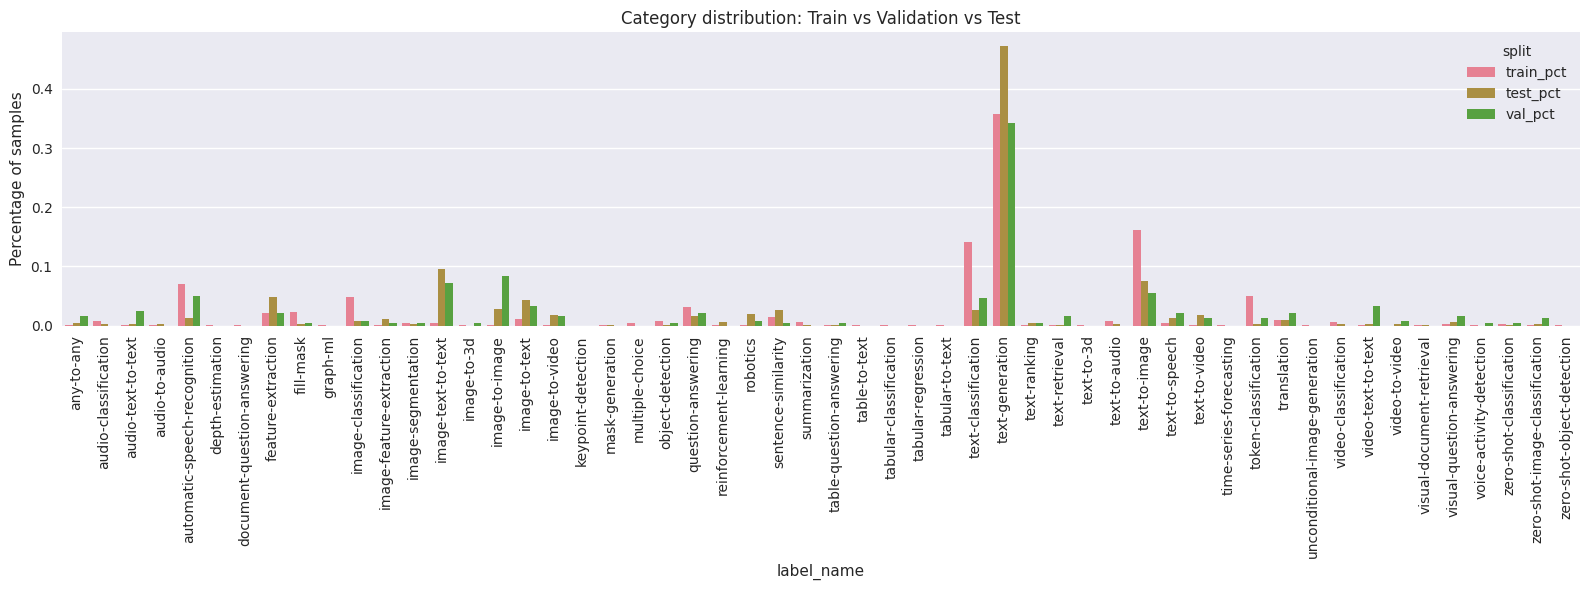

In [379]:
# Compare category distribution between train, validation, and test splits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Attempt to import scipy for p-value; fallback to chi-square only
try:
    from scipy.stats import chi2_contingency  # type: ignore
    _has_scipy = True
except Exception:
    _has_scipy = False

# Extract split label matrices
train_mask = data_own.train_mask
val_mask = data_own.val_mask
test_mask = data_own.test_mask
train_labels = data_own.y[train_mask].cpu().numpy()
val_labels = data_own.y[val_mask].cpu().numpy()
test_labels = data_own.y[test_mask].cpu().numpy()

# Sum counts per category
train_counts = train_labels.sum(axis=0)
val_counts = val_labels.sum(axis=0)
test_counts = test_labels.sum(axis=0)

# Build distribution DataFrame
dist_df = pd.DataFrame({
    'label_idx': np.arange(len(train_counts)),
    'label_name': [idx_to_task_own.get(i, str(i)) for i in range(len(train_counts))],
    'train_count': train_counts,
    'val_count': val_counts,
    'test_count': test_counts,
})

# Compute percentages
dist_df['train_pct'] = dist_df['train_count'] / dist_df['train_count'].sum()
dist_df['val_pct'] = dist_df['val_count'] / dist_df['val_count'].sum()
dist_df['test_pct'] = dist_df['test_count'] / dist_df['test_count'].sum()

# Show top categories with largest absolute percentage differences
dist_df['max_pct_diff'] = dist_df[['train_pct', 'val_pct', 'test_pct']].max(axis=1) - \
                          dist_df[['train_pct', 'val_pct', 'test_pct']].min(axis=1)
dist_df['val_test_diff'] = (dist_df['test_pct'] - dist_df['val_pct']).abs()
dist_df['train_val_diff'] = (dist_df['val_pct'] - dist_df['train_pct']).abs()
dist_df['train_test_diff'] = (dist_df['test_pct'] - dist_df['train_pct']).abs()

print("\n" + "="*60)
print("Top categories with largest distribution differences:")
display(dist_df.nlargest(20, 'max_pct_diff')[
    ['label_idx','label_name','train_pct','val_pct','test_pct','max_pct_diff']
])

# Plot side-by-side percentage bars for all three splits
plot_df = dist_df.melt(id_vars=['label_idx','label_name'],
                       value_vars=['train_pct','val_pct','test_pct'],
                       var_name='split', value_name='pct')
plt.figure(figsize=(16,6))
sns.barplot(data=plot_df.sort_values('label_name'), x='label_name', y='pct', hue='split')
plt.xticks(rotation=90)
plt.ylabel('Percentage of samples')
plt.title('Category distribution: Train vs Validation vs Test')
plt.tight_layout()
plt.show()


In [376]:
# chi2_contingency(contingency_pair)
contingency_pair

array([[ 81,   5,   3,   4,   1,   2,   5,   5,   0,   5,  12,   2,   1,
          1,   0,   4,   0,   8,   1,  13,   0,   0,  17,  11,   1,   1,
          4,   3,   1,   0,   1,   0,   0,   3,   4,  20,   0,   0,   0,
          0,   8,   0,   1,   6,   0,   0,   1,   0,   0,   0,   0,   0,
          2],
       [422,  15,  16,  16,   0,  17,   9,  43,   0,  11,  11,   7,   1,
          2,   0,   5,   1,  39,  10,  68,   3,   5,  85,  24,  23,   1,
          1,   3,   1,   2,   3,   0,   2,   3,   4,  25,   0,   0,   0,
          0,   3,   2,   0,   2,   0,   1,   4,   0,   0,   0,   1,   0,
          3]])

# Graph from paper

In [10]:
dataset_path='huggingface_bge.pt'
data = torch.load(dataset_path, weights_only=False)

In [63]:
# Load task to index mapping
print("Loading task label mappings...")

with open('task_to_id.txt', 'r') as f:
    task_id_list = f.readlines()
task_to_idx  = dict([(s.split('\t')[0].split(':')[-1],
                     int(s.split('\t')[-1].strip())) for s in task_id_list
                   ])
idx_to_task = {v: k for k, v in idx_to_task.items()}
print(f"Loaded {len(task_to_idx)} task labels")
print(f"Sample mappings: {dict(list(task_to_idx.items())[:5])}")

Loading task label mappings...
Loaded 52 task labels
Sample mappings: {'any-to-any': 0, 'audio-classification': 1, 'audio-text-to-text': 2, 'audio-to-audio': 3, 'automatic-speech-recognition': 4}


In [12]:

print("Starting EDA Analysis...")
print(f"Graph info: {data.num_nodes:,} nodes, {data.num_edges:,} edges")
print(f"Feature dimension: {data.x.shape[1]}")
print(f"Number of labels: {data.y.shape[1]}")


Starting EDA Analysis...
Graph info: 152,435 nodes, 166,199 edges
Feature dimension: 768
Number of labels: 52


In [76]:
df_lab = get_lab_dist(data, idx_to_task, show_top=False)

📊 LABEL DISTRIBUTION ANALYSIS
Total number of unique labels: 52
Total label instances: 160550.0
Average labels per node: 1.05
Max labels per node: 15.0
Min labels per node: 1.0
 Label_Index                      Task_Name  Total_Count  Total_Percentage
          33                text-generation      52726.0         32.840858
          37                  text-to-image      29649.0         18.467144
          32            text-classification      21012.0         13.087511
          40           text2text-generation       9988.0          6.221115
           4   automatic-speech-recognition       8718.0          5.430084
          42           token-classification       6634.0          4.132046
          10           image-classification       6086.0          3.790720
          22             question-answering       4055.0          2.525693
           7             feature-extraction       3931.0          2.448458
          25            sentence-similarity       3198.0          1.99190

In [80]:
data.train_mask.sum(), data.val_mask.sum(), data.test_mask.sum()

(tensor(105782), tensor(19308), tensor(27345))